# Analyze the best performing models of each type

In [1]:
import importlib

# Load modules
import os
import sys
from time import time
from scipy import stats
import pandas as pd
import numpy as np
import plotnine
from plotnine import *
# Load the help functions
import support.acc_funs
importlib.reload(support.acc_funs)
from support.acc_funs import fast_auc, fast_decomp, write_fast_decomp, write_fast_inference, gen_CI
from support.support_funs import makeifnot, decomp_var
from support.get_cpt_annotations import cpt_desciptions
from scipy.interpolate import UnivariateSpline


from scipy.stats import rankdata
from time import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# Set directories
dir_base = os.getcwd()
dir_NSQIP = os.path.join(dir_base,'..')
dir_output = os.path.join(dir_NSQIP, 'output')
dir_figures = os.path.join(dir_NSQIP, 'figures')
makeifnot(dir_figures)

di_model = {'logit':'Logistic-L2', 'rf':'RandomForest', 'xgb':'XGBoost'}
di_outcome = {'adv':'ADV', 'aki':'AKI', 'cns':'CNS',
              'nsi':'nSSIs', 'ssi':'SSIs', 'unplan':'UPLN'}
di_method = {'agg':'Aggregate', 'sub':'CPT-model'}

cpt_trans = cpt_desciptions()

In [2]:
# Dummy data to make sure fast approximations line up
y = np.array([1,1,1,1,0,0,0,1])
s = np.array([6,5,7,5,3,2,2,1])
g = np.array(['a','a','b','a','b','b','b','c'])
# print(fast_auc(y,s,both=False,den=False))
print(fast_decomp(y,s,g,ret_df=False))

        tt   auc  den  n1
0    total  0.80   15   5
1   within  1.00    3   5
2  between  0.75   12   0


## (1) Load in data

In [3]:
fn_output = pd.Series(os.listdir(dir_output))
fn_best = fn_output[fn_output.str.contains('.csv$') & fn_output.str.contains('^best')].reset_index(None,True)

fn_csv = 'df_best.csv'
check_csv = fn_csv in os.listdir(dir_output)
if not check_csv:
    print('Loading data via loop')
    holder = []
    cn_keep = ['model','outcome','test_year','cpt','y','preds']
    for fn in fn_best:
        print('Loading file: %s' % fn)
        path = os.path.join(dir_output, fn)
        tmp_df = pd.read_csv(path, usecols=cn_keep)  #, nrows=10
        tmp_df.rename(columns={'model':'method'},inplace=True)
        mdl = fn.split('.')[0].split('_')[-1]
        tmp_df.insert(0,'model',mdl)
        holder.append(tmp_df)
        del tmp_df
        #break
    df_nsqip = pd.concat(holder).reset_index(None, True)
    df_nsqip.outcome = df_nsqip.outcome.str.replace('agg_','')
    df_nsqip['version'] = df_nsqip.outcome.str.replace('[^0-9]','')
    df_nsqip.version = np.where(df_nsqip.version == '', '1', df_nsqip.version).astype(int)
    df_nsqip.outcome = df_nsqip.outcome.str.replace('[^a-z]','')
    del holder
    print('Writing to file')
    df_nsqip.to_csv(os.path.join(dir_output, fn_csv), index=False)
else:
    print('Loading large CSV file')
    df_nsqip = pd.read_csv(os.path.join(dir_output, fn_csv))
df_nsqip.head(2)

Loading large CSV file


,model,y,preds,cpt,test_year,outcome,method,version
0,xgb,0,0.000325,c24538,2016,nsi,agg,1
1,xgb,0,0.000952,c31541,2016,nsi,agg,1


In [4]:
#df_nsqip.groupby(['model','method']).size()
# CALCULATE THE NUMBER OF CPTS IN ANY GIVEN YEAR (PLOT....)


## (2) Decompose AUROCs within/between + CPTs (all years and no years)

In [5]:
# Decompose including the year
cn_gg1 = ['model','test_year','outcome','version','method']
fn_within_year = 'df_within_year.csv'
df_within_year = write_fast_decomp(df=df_nsqip, fn=fn_within_year, cn=cn_gg1, path=dir_output, ret_df=False)
# Repeat on the CPT level
fn_within_year_cpt = 'df_within_year_cpt.csv'
df_within_year_cpt = write_fast_decomp(df=df_nsqip, fn=fn_within_year_cpt, cn=cn_gg1, path=dir_output, ret_df=True)

# Decompose aggregating over years
cn_gg2 = ['model','outcome','version','method']
fn_within = 'df_within.csv'
df_within = write_fast_decomp(df=df_nsqip, fn=fn_within, cn=cn_gg2, path=dir_output, ret_df=False)
# Repeat on the CPT level
fn_within_cpt = 'df_within_cpt.csv'
df_within_cpt = write_fast_decomp(df=df_nsqip, fn=fn_within_cpt, cn=cn_gg2, path=dir_output, ret_df=True)

Decomposition already exists, loading: df_within_year.csv
Decomposition already exists, loading: df_within_year_cpt.csv
Decomposition already exists, loading: df_within.csv
Decomposition already exists, loading: df_within_cpt.csv


## (3) Find the "best" label and models

In [6]:
# Subset to within
sub_within = df_within.query('tt == "within" & method=="agg"').reset_index(None, True)#.drop(columns=['tt'])
gg_best = ['outcome','version','method']
best_outcome = sub_within.groupby(gg_best).auc.mean().reset_index()
best_outcome = best_outcome.sort_values(['outcome','auc'],ascending=[True,False]).groupby('outcome').head(1)
best_outcome = best_outcome.drop(columns='auc').reset_index(None,True)
best_mdl = sub_within.merge(best_outcome, 'inner', gg_best)
best_mdl = best_mdl.groupby(gg_best+['model']).apply(lambda x: np.sum(x.auc*x.den)/x.den.sum()).reset_index()
best_mdl = best_mdl.rename(columns={0:'auc'}).sort_values(['outcome','auc'],ascending=[True,False])
best_mdl = best_mdl.groupby(['outcome']).head(1).reset_index(None, True).drop(columns='auc')
print(best_outcome.head(2))
print(best_mdl.head(2))

  outcome  version method
0     adv        1    agg
1     aki        1    agg
  outcome  version method  model
0     adv        1    agg     rf
1     aki        1    agg  logit


## (4) Run inference on the "labels" and "models"

In [7]:
# Run on data without years
tmp_base = df_within.merge(best_outcome,'inner',gg_best).copy()
tmp_cpt = df_within_cpt.merge(best_outcome,'inner',gg_best).copy()

fn_within_inf = 'df_within_inf.csv'
df_within_inf = write_fast_inference(dat_base=tmp_base.copy(), dat_cpt=tmp_cpt.copy(), 
                     fn_write=fn_within_inf, path=dir_output, n_bs=1000, n_max=int(1e6))


tmp_base = df_within_year.merge(best_outcome,'inner',gg_best).copy()
tmp_cpt = df_within_year_cpt.merge(best_outcome,'inner',gg_best).copy()
fn_within_year_inf = 'df_within_year_inf.csv'
df_within_year_inf = write_fast_inference(dat_base=tmp_base.copy(), dat_cpt=tmp_cpt.copy(), 
                     fn_write=fn_within_year_inf, path=dir_output, n_bs=1000, n_max=int(1e6))

Bootstrapped samples already exist, loading
Bootstrapped samples already exist, loading


## (5) Get significance over CPTs

In [9]:
# GENERATE THE CONSTANTS NEEDED TO DO FINITE SAMPLE INFERENCE
if 'dat_var.csv' in os.listdir(dir_output):
    print('Loading variance constants')
    dat_var = pd.read_csv(os.path.join(dir_output, 'dat_var.csv'))
else:
    print('Generating variance constants')
    np.random.seed(1)
    nsim = 10000
    n1, n0 = 500, 500
    den = n1 * n0
    auc_seq = np.arange(0.5, 1, 0.01)
    holder = np.zeros(len(auc_seq))
    for i, auc in enumerate(auc_seq):
        print(i)
        mu = np.sqrt(2) * stats.norm.ppf(auc)
        Eta = np.r_[np.random.randn(n1, nsim)+mu, np.random.randn(n0,nsim)]
        Y = np.r_[np.zeros([n1,nsim],dtype=int)+1, np.zeros([n0,nsim],dtype=int)]
        R1 = np.apply_along_axis(func1d=stats.rankdata,arr=Eta,axis=0)[:n1]
        Amat = (R1.sum(0) - n1*(n1+1)/2) / den
        holder[i] = (n0+n1+1) / Amat.var() / den
    dat_var = pd.DataFrame({'auc':auc_seq, 'c':holder})
    dat_var = pd.concat([dat_var.iloc[1:].assign(auc=lambda x: 1-x.auc), dat_var]).sort_values('auc').reset_index(None, True)
    dat_var.to_csv(os.path.join(dir_output, 'dat_var.csv'),index=False)

spl = UnivariateSpline(x=dat_var.auc, y=dat_var.c)
# Find relationships between the statistically significant CPTs
cn = ['model','outcome']
dat_cpt_sig = df_within_cpt.merge(best_outcome)
dat_cpt_sig = dat_cpt_sig.assign(se=lambda x: np.sqrt((x.n1+x.n0+1)/spl(dat_cpt_sig.auc)/x.n0n1))
dat_cpt_sig = dat_cpt_sig.drop(columns=['r_s','n1','n0']).rename(columns={'g':'cpt'})
dat_cpt_sig = pd.concat([dat_cpt_sig,gen_CI(x=dat_cpt_sig.auc, se=dat_cpt_sig.se, alpha=0.05)],1)
dat_cpt_sig[['lb','ub']] = dat_cpt_sig[['lb','ub']].clip(lower=0,upper=1)
dat_cpt_sig = dat_cpt_sig.assign(is_sig=lambda x: x.lb > 0.5)
agg_cpt_sig = dat_cpt_sig.groupby(cn+['is_sig']).size().reset_index().rename(columns={0:'n'})
agg_cpt_sig = agg_cpt_sig.pivot_table('n',cn,'is_sig').fillna(0).astype(int).reset_index().melt(cn)
agg_cpt_sig = agg_cpt_sig.rename(columns={'value':'n'}).sort_values(cn).reset_index(None,True)
agg_cpt_sig = agg_cpt_sig.merge(agg_cpt_sig.groupby(cn).n.sum().reset_index().rename(columns={'n':'tot'}))
agg_cpt_sig = agg_cpt_sig.assign(pct=lambda x: x.n/x.tot)
dat_cpt_sig = pd.concat([dat_cpt_sig,cpt_trans.trans(dat_cpt_sig.cpt.values)],1)
dat_cpt_sig.group = dat_cpt_sig.group.str.replace('Surgical\\sProcedures\\son\\sthe\\s','').str.replace('\\sSystem','')

Loading variance constants


In [10]:
# Get the "best" model and check for organ enrichment
dat_cpt_sig_mdl = dat_cpt_sig.merge(best_mdl,'inner')
sig_organ = dat_cpt_sig_mdl.pivot_table(index='organ',columns='is_sig',values='cpt',aggfunc='size', fill_value=0)
sig_group = dat_cpt_sig_mdl.pivot_table(index='group',columns='is_sig',values='cpt',aggfunc='size', fill_value=0)
sig_both = pd.concat([sig_organ.reset_index().rename(columns={'organ':'term'}).assign(tt='organ'),
           sig_group.reset_index().rename(columns={'group':'term'}).assign(tt='group')]).reset_index(None,True)
sig_both.rename(columns={False:'false1',True:'true1'},inplace=True)
sig_both = sig_both.assign(tot_true=dat_cpt_sig_mdl.is_sig.sum(), tot_false=np.sum(~dat_cpt_sig_mdl.is_sig))
sig_both = sig_both.assign(false0=lambda x: x.tot_false-x.false1, true0=lambda x: x.tot_true-x.true1)
sig_both = sig_both.assign(lOR=lambda x: np.log(x.true1*x.false0/(x.true0*x.false1)),
                se=lambda x: np.sqrt(1/x.false1+1/x.true1+1/x.false0+1/x.true0))
sig_both = sig_both.assign(zscore=lambda x: x.lOR/x.se).assign(pval=lambda x: 2*(1-stats.norm.cdf(np.abs(x.zscore))))
sig_both.term = pd.Categorical(sig_both.term,sig_both.sort_values('lOR',ascending=False).term.values)

## (5) Figures

### (5.A) Variation between models/years

There is little variation between models in performance. Exception for a few kidney models in some years. Also shows that for any given model, there is very little variation between years. 

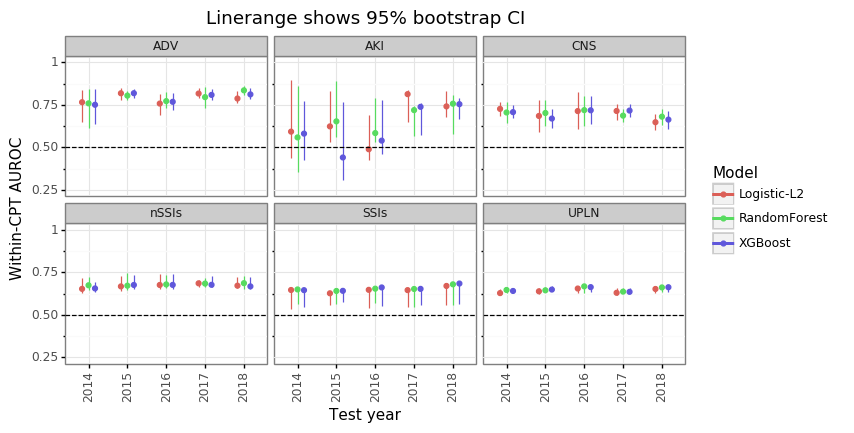

<ggplot: (2935668052684)>

In [11]:
tmp = df_within_year_inf.query('tt=="within"').assign(model=lambda x: x.model.map(di_model)).copy()
posd = position_dodge(0.5)
w, h= 8, 4
plotnine.options.figure_size = (w, h)
gg_auc_within = (ggplot(tmp, aes(x='test_year.astype(str)',y='auc',color='model')) + 
                 theme_bw() + geom_point(position=posd) + 
                 geom_linerange(aes(ymin='lb',ymax='ub'),position=posd) + 
                 facet_wrap('~outcome',labeller=labeller(outcome=di_outcome)) + 
                 theme(axis_text_x=element_text(angle=90)) + #,axis_ticks_minor_y=element_blank()
                 labs(y='Within-CPT AUROC',x='Test year') + 
                 scale_y_continuous(limits=[0.25,1],breaks=list(np.arange(0.25,1.01,0.25))) + 
                 geom_hline(yintercept=0.5,linetype='--') + 
                 scale_color_discrete(name='Model') + 
                 ggtitle('Linerange shows 95% bootstrap CI'))
# gg_auc_within.save(os.path.join(dir_figures,'gg_auc_within.png'),base_height=h, base_width=w, verbose=False)
gg_auc_within

### (5.B) Variation between decomp/years

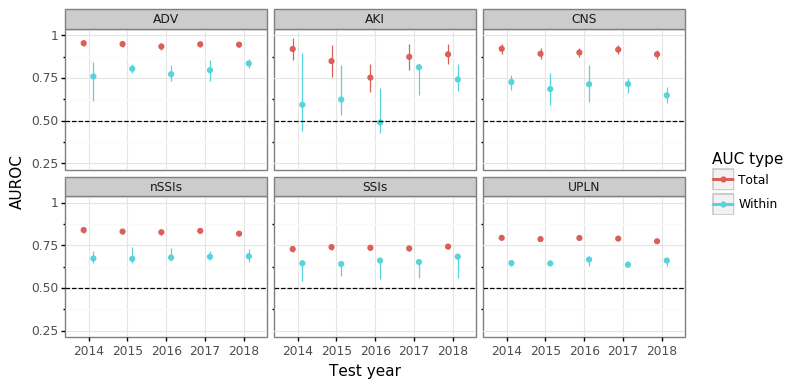

<ggplot: (2935668732073)>

In [12]:
tmp = df_within_year_inf.merge(best_mdl)
w, h = 8, 4
posd = position_dodge(0.5)
plotnine.options.figure_size = (w, h)
gg_between = (ggplot(tmp,aes(x='test_year.astype(str)',y='auc',color='tt')) + 
              theme_bw() + geom_point(position=posd) + 
              facet_wrap('~outcome',labeller=labeller(outcome=di_outcome)) + 
              scale_color_discrete(name='AUC type',labels=['Total','Within']) + 
              geom_linerange(aes(ymin='lb',ymax='ub'),position=posd) + 
              labs(y='AUROC',x='Test year') + 
              geom_hline(yintercept=0.5,linetype='--') + 
              scale_y_continuous(limits=[0.25,1],breaks=list(np.arange(0.25,1.01,0.25))))
gg_between

### (5.C) Distribution within the "within"

/home/edrysdale/.local/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_histogram : Removed 12 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


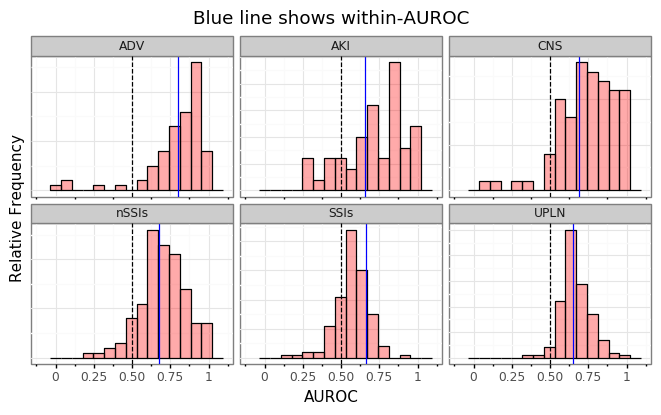

<ggplot: (2935669317149)>

In [13]:
tmp1 = df_within.merge(best_mdl).query('tt=="within"').reset_index(None,True).copy()
tmp2 = df_within_cpt.merge(best_mdl).reset_index(None,True).copy()

w, h = 8, 4
plotnine.options.figure_size = (w, h)
gg_dist_cpt = (ggplot(tmp2, aes(x='auc')) + theme_bw() + 
              geom_histogram(bins=18,color='black',fill='red',alpha=1/3) + 
              facet_wrap('~outcome',scales='free_y',labeller=labeller(outcome=di_outcome)) + 
              labs(x='AUROC', y='Relative Frequency') + 
              scale_x_continuous(limits=[-0.1,1.1],breaks=list(np.arange(0,1.1,0.25))) + 
              theme(axis_text_y=element_blank(),axis_ticks_minor_y=element_blank(),
                    axis_ticks_major_y=element_blank()) + 
              geom_vline(aes(xintercept='auc'),data=tmp1,color='blue') + 
              ggtitle('Blue line shows within-AUROC') + 
              geom_vline(xintercept=0.5,linetype='--'))
gg_dist_cpt

### (5.D) CPT signficance

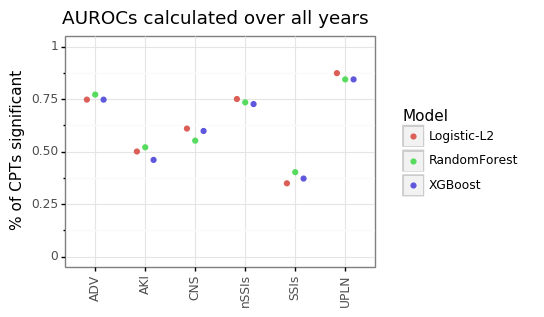

<ggplot: (2935669497790)>

In [14]:
w, h= 4, 3
plotnine.options.figure_size = (w, h)
tmp = agg_cpt_sig.query('is_sig==True').assign(outcome=lambda x: 
       pd.Categorical(x.outcome,dat_cpt_sig.outcome.unique()).map(di_outcome),
      model=lambda x: x.model.map(di_model))

posd = position_dodge(0.5)
gg_sig = (ggplot(tmp,aes(x='outcome',y='pct',color='model')) + theme_bw() + 
          geom_point(position=posd) + 
         theme(axis_title_x=element_blank(),axis_text_x=element_text(angle=90)) + 
         scale_color_discrete(name='Model') + 
         labs(y='% of CPTs significant') + 
         ggtitle('AUROCs calculated over all years') + 
         scale_y_continuous(limits=[0,1]))
gg_sig

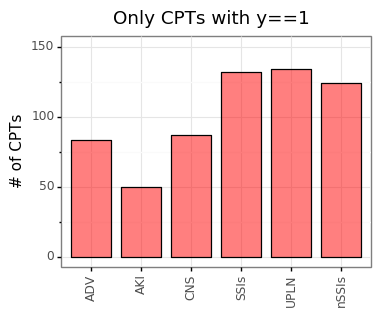

<ggplot: (2935671682301)>

In [15]:
n_cpts_mdl = df_within_cpt.merge(best_mdl).groupby(['outcome']).size().reset_index().rename(columns={0:'tot'})
n_cpts_mdl.outcome = n_cpts_mdl.outcome.map(di_outcome)

w, h = 4, 3
plotnine.options.figure_size = (w, h)
gg_n_cpts_mdl = (ggplot(n_cpts_mdl,aes(x='outcome',y='tot')) + theme_bw() + 
                  geom_bar(stat='identity',color='black',fill='red',alpha=0.5,width=0.8) + 
                 theme(axis_title_x=element_blank(),axis_text_x=element_text(angle=90)) + 
                 labs(y='# of CPTs') + 
                 scale_y_continuous(limits=[0,150]) + 
                 ggtitle('Only CPTs with y==1'))
gg_n_cpts_mdl

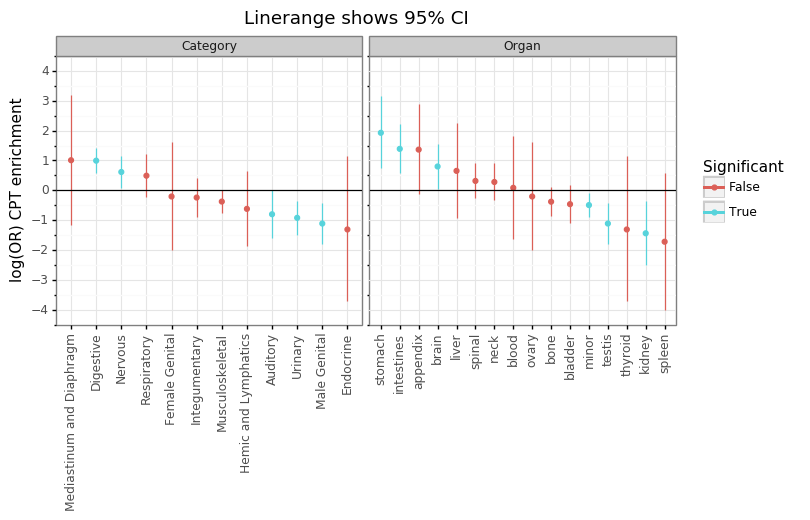

<ggplot: (2935671716279)>

In [16]:
w, h= 8, 3.5
plotnine.options.figure_size = (w, h)
gg_sig = (ggplot(sig_both,aes(x='term',y='lOR',color='pval<0.05')) + theme_bw() + 
          geom_point() + geom_linerange(aes(ymin='lOR-1.96*se',ymax='lOR+2*se')) + 
          facet_wrap('~tt',scales='free_x',labeller=labeller(tt={'group':'Category','organ':'Organ'})) + 
         theme(axis_title_x=element_blank(),axis_text_x=element_text(angle=90)) + 
         geom_hline(yintercept=0) + 
         scale_y_continuous(limits=[-4.1,4.1],breaks=list(np.arange(-4,4.1,1))) + 
         labs(y='log(OR) CPT enrichment') + 
         ggtitle('Linerange shows 95% CI') + 
         scale_color_discrete(name='Significant'))
gg_sig